In [4]:
import os
import pprint
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import torch
import pyarrow.dataset as ds
import pyarrow as pa

data_folder = os.path.join(".", os.pardir, os.pardir, "data")
raw_data_folder = os.path.join(data_folder, "RAW")
processed_data_folder = os.path.join(data_folder, "processed")

print(data_folder)
print(raw_data_folder)
print(processed_data_folder)


./../../data
./../../data/RAW
./../../data/processed


## ARotor replication (newer dataset)

Kongsberg test rig

### Faults


In [50]:
dfs = []
# data_folder = os.path.join("data", "RAW", "ARotor_replication", "Faults")
for dirpath, dirnames, filenames in os.walk(os.path.join(raw_data_folder, "ARotor_replication", "Faults")):
    # print(dirnames)
    dirpath_parts = dirpath.split("/")
    for filename in filenames:
        if filename.split(".")[-1] == "feather":
            # if not filename[0] == ".":
            # print(dirpath, filename)
            name_parts = filename.split("_")

            print(name_parts)
            print(dirpath_parts)
            print()


['750rpm', 'CT', 'failure', '11%', 'GP6', '0.feather']
['.', '..', '..', 'data', 'RAW', 'ARotor_replication', 'Faults', 'GP6_severe_pitting', 'data_set_2', '3012Hz', 'sensor']

['750rpm', 'CT', 'failure', '6%', 'GP6', '0.feather']
['.', '..', '..', 'data', 'RAW', 'ARotor_replication', 'Faults', 'GP6_severe_pitting', 'data_set_2', '3012Hz', 'sensor']

['1250rpm', 'CT', 'failure', '11%', 'GP6', '0.feather']
['.', '..', '..', 'data', 'RAW', 'ARotor_replication', 'Faults', 'GP6_severe_pitting', 'data_set_2', '3012Hz', 'sensor']

['1000rpm', 'CT', 'failure', '6%', 'GP6', '0.feather']
['.', '..', '..', 'data', 'RAW', 'ARotor_replication', 'Faults', 'GP6_severe_pitting', 'data_set_2', '3012Hz', 'sensor']

['750rpm', 'CT', 'failure', '1%', 'GP6', '0.feather']
['.', '..', '..', 'data', 'RAW', 'ARotor_replication', 'Faults', 'GP6_severe_pitting', 'data_set_2', '3012Hz', 'sensor']

['1000rpm', 'CT', 'failure', '1%', 'GP6', '0.feather']
['.', '..', '..', 'data', 'RAW', 'ARotor_replication', 'Fault

In [25]:
dfs = []
# data_folder = os.path.join("data", "RAW", "ARotor_replication", "Faults")
for dirpath, dirnames, filenames in os.walk(os.path.join(raw_data_folder, "ARotor_replication", "Faults")):
    # print(dirnames)
    dirpath_parts = dirpath.split("/")
    for filename in filenames:
        if filename.split(".")[-1] == "feather":
            # if not filename[0] == ".":
            # print(dirpath, filename)
            name_parts = filename.split("_")

            print(dirpath_parts[7], dirpath_parts[8][-1], name_parts[0], name_parts[3], name_parts[4])

            # Load &
            # cut acceleration and deceleration
            pth = os.path.join(dirpath, filename)
            # print(pth)
            df_tmp = pd.read_feather(pth)
            df_tmp = df_tmp.iloc[int(len(df_tmp) * 0.2) : int(len(df_tmp) * 0.8)].reset_index(drop=True)

            # Get non-encoder sensors
            df = df_tmp[["acc1", "acc2", "acc3", "acc4", "Torq1", "Torq2"]]
            # Flip torques and standardize naming
            df = df.rename({"Torq2": "torque1", "Torq1": "torque2"}, axis="columns")

            # Encoders
            df_enc_tmp = df_tmp.loc[
                :,
                [
                    "enc1_time",
                    "enc1_ang",
                    "enc2_time",
                    "enc2_ang",
                    "enc3_time",
                    "enc3_ang",
                    "enc4_time",
                    "enc4_ang",
                    "enc5_time",
                    "enc5_ang",
                ],
            ]

            df_enc = []
            for i in range(1, 6):
                # Encoder 4 runs the wrong way (in most cases, but no all for some reason) so its angles must be reversed
                if df_enc_tmp[f"enc{i}_ang"][0] < 0:
                    # if df_enc_tmp[f"enc{i}_ang"][0] > df_enc_tmp[f"enc{i}_ang"][1]:
                    print(f"Encoder {i} runs the wrong way in file {filename}!")
                    df_enc_tmp[f"enc{i}_ang"] = df_enc_tmp[f"enc{i}_ang"] * (-1)

                speed = np.gradient(df_enc_tmp[f"enc{i}_ang"], df_enc_tmp[f"enc{i}_time"])
                acc = np.gradient(speed, df_enc_tmp[f"enc{i}_time"])

                df_enc.append(
                    pd.DataFrame(
                        {
                            f"en{i}speed": speed,
                            f"en{i}acc": acc,
                        }
                    )
                )
            # Combine sensors
            df = pd.concat([df, *df_enc], axis=1)

            # Add other info
            df["rpm"] = int(name_parts[0].replace("rpm", ""))
            df["torque"] = int(name_parts[3].replace("%", ""))
            # df["class"] = "_".join(dirpath_parts[7].split("_")[1:])
            df["severity"] = dirpath_parts[7].split("_")[1]
            df["fault"] = dirpath_parts[7].split("_")[2]
            df["installation"] = dirpath_parts[8][-1]
            # df["damage"] = dirpath_parts[4].split("_")[2]
            # df["severity"] = dirpath_parts[4].split("_")[1]

            dfs.append(df)

dfs = pd.concat(dfs)

# * Conversion done because final computations are done with float32 anyway
# Get float 64 columns
float64_cols = list(dfs.select_dtypes(include="float64"))
# Convert those columns float 32
dfs[float64_cols] = dfs[float64_cols].astype("float32")

dfs = dfs.reset_index(drop=True)

dfs.head(3)


GP6_severe_pitting 750rpm 11% GP6
Encoder 4 runs the wrong way in file 750rpm_CT_failure_11%_GP6_0.feather!
GP6_severe_pitting 750rpm 6% GP6
Encoder 4 runs the wrong way in file 750rpm_CT_failure_6%_GP6_0.feather!
GP6_severe_pitting 1250rpm 11% GP6
Encoder 4 runs the wrong way in file 1250rpm_CT_failure_11%_GP6_0.feather!
GP6_severe_pitting 1000rpm 6% GP6
Encoder 4 runs the wrong way in file 1000rpm_CT_failure_6%_GP6_0.feather!
GP6_severe_pitting 750rpm 1% GP6
Encoder 4 runs the wrong way in file 750rpm_CT_failure_1%_GP6_0.feather!
GP6_severe_pitting 1000rpm 1% GP6
Encoder 4 runs the wrong way in file 1000rpm_CT_failure_1%_GP6_0.feather!
GP6_severe_pitting 1500rpm 11% GP6
Encoder 4 runs the wrong way in file 1500rpm_CT_failure_11%_GP6_0.feather!
GP6_severe_pitting 500rpm 11% GP6
Encoder 4 runs the wrong way in file 500rpm_CT_failure_11%_GP6_0.feather!
GP6_severe_pitting 250rpm 11% GP6
Encoder 4 runs the wrong way in file 250rpm_CT_failure_11%_GP6_0.feather!
GP6_severe_pitting 500rpm 6%

/Users/hamalaa14/opt/miniconda3/envs/torch/lib/python3.9/site-packages/numpy/lib/function_base.py:1239: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/Users/hamalaa14/opt/miniconda3/envs/torch/lib/python3.9/site-packages/numpy/lib/function_base.py:1239: RuntimeWarning: invalid value encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/Users/hamalaa14/opt/miniconda3/envs/torch/lib/python3.9/site-packages/numpy/lib/function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/Users/hamalaa14/opt/miniconda3/envs/torch/lib/python3.9/site-packages/numpy/lib/function_base.py:1240: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/Users/hamalaa14/opt/miniconda3/envs/torch/lib/python3.9/site-packages/numpy/lib/function_base.py:1241: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/Users/hamalaa14/opt/miniconda3/envs/torch/lib/python3.

Encoder 4 runs the wrong way in file 250rpm_CT_failure_11%_GP9_0.feather!
GP9_mild_tff 500rpm 11% GP9
Encoder 4 runs the wrong way in file 500rpm_CT_failure_11%_GP9_0.feather!
GP9_mild_tff 1250rpm 1% GP9
Encoder 4 runs the wrong way in file 1250rpm_CT_failure_1%_GP9_0.feather!
GP9_mild_tff 500rpm 1% GP9
Encoder 4 runs the wrong way in file 500rpm_CT_failure_1%_GP9_0.feather!
GP9_mild_tff 1250rpm 6% GP9
Encoder 4 runs the wrong way in file 1250rpm_CT_failure_6%_GP9_0.feather!
GP9_mild_tff 500rpm 6% GP9
Encoder 4 runs the wrong way in file 500rpm_CT_failure_6%_GP9_0.feather!
GP9_mild_tff 250rpm 1% GP9
Encoder 4 runs the wrong way in file 250rpm_CT_failure_1%_GP9_0.feather!
GP9_mild_tff 1500rpm 1% GP9
Encoder 4 runs the wrong way in file 1500rpm_CT_failure_1%_GP9_0.feather!
GP9_mild_tff 250rpm 6% GP9
Encoder 4 runs the wrong way in file 250rpm_CT_failure_6%_GP9_0.feather!
GP9_mild_tff 1500rpm 6% GP9
Encoder 4 runs the wrong way in file 1500rpm_CT_failure_6%_GP9_0.feather!
GP9_mild_tff 100

KeyboardInterrupt: 

In [31]:
dfs.to_feather(os.path.join(processed_data_folder, "arotor_replication_faults.feather"))


In [128]:
from pyarrow._dataset import FileFormat


In [132]:
# rpms = [1000]
# installations = [1]
rpms = [250, 500, 750, 1000, 1250, 1500]
installations = [1, 2]

partitions = ds.partitioning(pa.schema([("rpm", pa.int16()), ("installation", pa.int8())]), flavor="hive")

for r in rpms:
    for ins in installations:
        dfs = []

        # FAULTS
        ###
        for dirpath, dirnames, filenames in os.walk(os.path.join(raw_data_folder, "ARotor_replication", "Faults")):
            # print(dirnames)
            dirpath_parts = dirpath.split("/")
            for filename in filenames:
                if filename.split(".")[-1] == "feather":
                    name_parts = filename.split("_")

                    if int(name_parts[0].replace("rpm", "")) == r and int(dirpath_parts[8][-1]) == ins:
                        print(dirpath_parts[7], dirpath_parts[8], name_parts[0], name_parts[3], name_parts[4])

                        # Load
                        pth = os.path.join(dirpath, filename)
                        # print(pth)
                        df_tmp = pd.read_feather(pth)
                        # Cut acceleration and deceleration
                        df_tmp = df_tmp.iloc[int(len(df_tmp) * 0.2) : int(len(df_tmp) * 0.8)].reset_index(drop=True)

                        # Get non-encoder sensors
                        df = df_tmp[["acc1", "acc2", "acc3", "acc4", "Torq1", "Torq2"]]
                        # Flip torques and standardize naming
                        df = df.rename({"Torq2": "torque1", "Torq1": "torque2"}, axis="columns")

                        # Encoders
                        df_enc_tmp = df_tmp.loc[
                            :,
                            [
                                "enc1_time",
                                "enc1_ang",
                                "enc2_time",
                                "enc2_ang",
                                "enc3_time",
                                "enc3_ang",
                                "enc4_time",
                                "enc4_ang",
                                "enc5_time",
                                "enc5_ang",
                            ],
                        ]

                        df_enc = []
                        for i in range(1, 6):
                            # Encoder 4 runs the wrong way (in most cases, but no all for some reason) so its angles must be reversed
                            if df_enc_tmp[f"enc{i}_ang"][0] < 0:
                                # if df_enc_tmp[f"enc{i}_ang"][0] > df_enc_tmp[f"enc{i}_ang"][1]:
                                print(f"Encoder {i} runs the wrong way in file {filename}!")
                                df_enc_tmp[f"enc{i}_ang"] = df_enc_tmp[f"enc{i}_ang"] * (-1)

                            speed = np.gradient(df_enc_tmp[f"enc{i}_ang"], df_enc_tmp[f"enc{i}_time"])
                            acc = np.gradient(speed, df_enc_tmp[f"enc{i}_time"])

                            df_enc.append(
                                pd.DataFrame(
                                    {
                                        f"en{i}speed": speed,
                                        f"en{i}acc": acc,
                                    }
                                )
                            )
                        # Combine sensors
                        df = pd.concat([df, *df_enc], axis=1)

                        # Add other info
                        df["rpm"] = int(name_parts[0].replace("rpm", ""))
                        df["torque"] = int(name_parts[3].replace("%", ""))
                        df["severity"] = dirpath_parts[7].split("_")[1]  # TODO Categorical
                        df["fault"] = dirpath_parts[7].split("_")[2]  # TODO Categorical
                        df["installation"] = int(dirpath_parts[8][-1])

                        dfs.append(df)

        # SAVE
        ##

        if len(dfs) > 0:
            dfs = pd.concat(dfs)
            print("Writing partition")

            # Get float 64 columns to flaot 32
            # * Conversion done because final computations are done with float32 anyway
            float64_cols = list(dfs.select_dtypes(include="float64"))
            dfs[float64_cols] = dfs[float64_cols].astype("float32")

            # Convert categoricals
            dfs["severity"] = dfs["severity"].astype("category")
            dfs["fault"] = dfs["fault"].astype("category")

            dfs = dfs.reset_index(drop=True)
            table = pa.Table.from_pandas(dfs)

            ds.write_dataset(
                table,
                os.path.join(processed_data_folder, "arotor_replication_faults_ds"),
                format="feather",
                partitioning=partitions,
                existing_data_behavior="overwrite_or_ignore",
            )


TypeError: IpcFileFormat.make_write_options() takes no keyword arguments

### Baseline


In [73]:
dfs = []
# data_folder = os.path.join("data", "RAW", "ARotor_replication", "Faults")
for dirpath, dirnames, filenames in os.walk(os.path.join(raw_data_folder, "ARotor_replication", "Baseline")):
    # print(dirnames)
    dirpath_parts = dirpath.split("/")
    for filename in filenames:
        if filename.split(".")[-1] == "feather":
            # if not filename[0] == "." or "README" in filename:
            # print(dirpath, filename)
            name_parts = filename.split("_")

            print(dirpath_parts[7], name_parts[0], name_parts[3], name_parts[4])

            # Load &
            # cut acceleration and deceleration
            pth = os.path.join(dirpath, filename)
            # print(pth)
            df_tmp = pd.read_feather(pth)
            df_tmp = df_tmp.iloc[int(len(df_tmp) * 0.25) : int(len(df_tmp) * 0.75)].reset_index(drop=True)

            # Get non-encoder sensors
            df = df_tmp[["acc1", "acc2", "acc3", "acc4", "Torq1", "Torq2"]]
            # Flip torques and standardize naming
            df = df.rename({"Torq1": "torque2", "Torq2": "torque1"}, axis="columns")

            # # Encoders
            df_enc_tmp = df_tmp.loc[
                :,
                [
                    "enc1_time",
                    "enc1_ang",
                    "enc2_time",
                    "enc2_ang",
                    "enc3_time",
                    "enc3_ang",
                    "enc4_time",
                    "enc4_ang",
                    "enc5_time",
                    "enc5_ang",
                ],
            ]

            df_enc = []
            for i in range(1, 6):
                # Encoder 4 runs the wrong way (in most cases, but no all for some reason) so its angles must be reversed
                if df_enc_tmp[f"enc{i}_ang"][0] < 0:
                    # if df_enc_tmp[f"enc{i}_ang"][0] > df_enc_tmp[f"enc{i}_ang"][1]:
                    print(f"Encoder {i} runs the wrong way in file {filename}!")
                    df_enc_tmp[f"enc{i}_ang"] = df_enc_tmp[f"enc{i}_ang"] * (-1)

                speed = np.gradient(df_enc_tmp[f"enc{i}_ang"], df_enc_tmp[f"enc{i}_time"])
                acc = np.gradient(speed, df_enc_tmp[f"enc{i}_time"])

                df_enc.append(
                    pd.DataFrame(
                        {
                            f"en{i}speed": speed,
                            f"en{i}acc": acc,
                        }
                    )
                )
            # Combine sensors
            df = pd.concat([df, *df_enc], axis=1)

            # # Add other info
            df["rpm"] = int(name_parts[0].replace("rpm", ""))
            df["torque"] = int(name_parts[3].replace("%", ""))
            # df["class"] = "_".join(["baseline", name_parts[4]])
            df["fault"] = "baseline"
            df["severity"] = int(name_parts[4].replace("GP", ""))

            dfs.append(df)

dfs = pd.concat(dfs)

# * Conversion done because final computations are done with float32 anyway
# Get float 64 columns
float64_cols = list(dfs.select_dtypes(include="float64"))
# Convert those columns float 32
dfs[float64_cols] = dfs[float64_cols].astype("float32")

dfs = dfs.reset_index(drop=True)

dfs.head(3)


GP9 1250rpm 11% GP9
Encoder 4 runs the wrong way in file 1250rpm_CT_baseline_11%_GP9_0_0,21_0,7.feather!
GP9 1250rpm 1% GP9
Encoder 4 runs the wrong way in file 1250rpm_CT_baseline_1%_GP9_0_0,25_0,75.feather!
GP9 1000rpm 11% GP9
Encoder 4 runs the wrong way in file 1000rpm_CT_baseline_11%_GP9_0_0,2_0,78.feather!
GP9 750rpm 11% GP9
Encoder 4 runs the wrong way in file 750rpm_CT_baseline_11%_GP9_0_0,2_0,8.feather!
GP9 500rpm 1% GP9
Encoder 4 runs the wrong way in file 500rpm_CT_baseline_1%_GP9_0_0,17_0,83.feather!
GP9 1500rpm 11% GP9
Encoder 4 runs the wrong way in file 1500rpm_CT_baseline_11%_GP9_0_0,25_0,73.feather!
GP9 750rpm 6% GP9
Encoder 4 runs the wrong way in file 750rpm_CT_baseline_6%_GP9_0_0,2_0,8.feather!
GP9 750rpm 1% GP9
Encoder 4 runs the wrong way in file 750rpm_CT_baseline_1%_GP9_0_0,2_0,8.feather!
GP9 1000rpm 1% GP9
Encoder 4 runs the wrong way in file 1000rpm_CT_baseline_1%_GP9_0_0,2_0,78.feather!
GP9 1250rpm 6% GP9
Encoder 4 runs the wrong way in file 1250rpm_CT_baseli

,acc1,acc2,acc3,acc4,torque2,torque1,en1speed,en1acc,en2speed,en2acc,en3speed,en3acc,en4speed,en4acc,en5speed,en5acc,rpm,torque,fault,severity
0,-30.233200,-31.878832,-6.921825,-23.480320,14.226685,1.785400,7544.097656,-54813.449219,7480.575684,87112.757812,2510.231934,8100.887695,2503.931396,-32101.105469,611.998901,-2909.916748,1250,11,baseline,9
1,25.162571,-29.432110,4.601814,-1.849042,14.248962,1.873901,7525.918945,-42635.726562,7509.502441,144475.968750,2512.904053,-8530.528320,2493.316162,-38671.816406,611.057434,1311.545410,1250,11,baseline,9
2,-37.174038,89.537674,21.207041,41.107559,14.376526,1.996460,7515.788086,30709.574219,7576.483887,49857.679688,2504.633545,-24526.191406,2478.208008,-23464.378906,612.857300,8667.082031,1250,11,baseline,9


In [76]:
dfs.to_feather(os.path.join(processed_data_folder, "arotor_replication_baseline.feather"))


In [75]:
dfs.dtypes


acc1        float32
acc2        float32
acc3        float32
acc4        float32
torque2     float32
torque1     float32
en1speed    float32
en1acc      float32
en2speed    float32
en2acc      float32
en3speed    float32
en3acc      float32
en4speed    float32
en4acc      float32
en5speed    float32
en5acc      float32
rpm           int64
torque        int64
fault        string
severity      int64
dtype: object

In [37]:
print(dfs.groupby(["fault", "severity", "rpm", "torque"]).size().to_string())


fault     severity  rpm   torque
baseline  1         500   1         247375
                          6         247900
                          11        245925
                    750   1         277625
                          6         282225
                          11        279575
                    1000  1         312550
                          6         305275
                          11        307750
                    1250  1         325375
                          6         341325
                          11        339950
                    1500  1         370325
                          6         371775
                          11        372600
          2         500   1         246750
                          6         248250
                          11        250500
                    750   1         278250
                          6         278500
                          11        310500
                    1000  1         309500
                     

In [134]:
# rpms = [1000]
# installations = [1]
rpms = [250, 500, 750, 1000, 1250, 1500]

partitions = ds.partitioning(pa.schema([("rpm", pa.int16()), ("installation", pa.int8())]), flavor="hive")

for r in rpms:
    dfs = []

    # BASELINE
    ##
    for dirpath, dirnames, filenames in os.walk(os.path.join(raw_data_folder, "ARotor_replication", "Baseline")):
        # print(dirnames)
        dirpath_parts = dirpath.split("/")
        for filename in filenames:
            if filename.split(".")[-1] == "feather":
                name_parts = filename.split("_")

                if int(name_parts[0].replace("rpm", "")) == r:
                    print(dirpath_parts[7], name_parts[0], name_parts[3], name_parts[4])

                    # Load
                    pth = os.path.join(dirpath, filename)
                    # print(pth)
                    df_tmp = pd.read_feather(pth)
                    # Cut acceleration and deceleration
                    df_tmp = df_tmp.iloc[int(len(df_tmp) * 0.25) : int(len(df_tmp) * 0.75)].reset_index(drop=True)

                    # Get non-encoder sensors
                    df = df_tmp[["acc1", "acc2", "acc3", "acc4", "Torq1", "Torq2"]]
                    # Flip torques and standardize naming
                    df = df.rename({"Torq1": "torque2", "Torq2": "torque1"}, axis="columns")

                    # # Encoders
                    df_enc_tmp = df_tmp.loc[
                        :,
                        [
                            "enc1_time",
                            "enc1_ang",
                            "enc2_time",
                            "enc2_ang",
                            "enc3_time",
                            "enc3_ang",
                            "enc4_time",
                            "enc4_ang",
                            "enc5_time",
                            "enc5_ang",
                        ],
                    ]

                    df_enc = []
                    for i in range(1, 6):
                        # Encoder 4 runs the wrong way (in most cases, but no all for some reason) so its angles must be reversed
                        if df_enc_tmp[f"enc{i}_ang"][0] < 0:
                            # if df_enc_tmp[f"enc{i}_ang"][0] > df_enc_tmp[f"enc{i}_ang"][1]:
                            print(f"Encoder {i} runs the wrong way in file {filename}!")
                            df_enc_tmp[f"enc{i}_ang"] = df_enc_tmp[f"enc{i}_ang"] * (-1)

                        speed = np.gradient(df_enc_tmp[f"enc{i}_ang"], df_enc_tmp[f"enc{i}_time"])
                        acc = np.gradient(speed, df_enc_tmp[f"enc{i}_time"])

                        df_enc.append(
                            pd.DataFrame(
                                {
                                    f"en{i}speed": speed,
                                    f"en{i}acc": acc,
                                }
                            )
                        )
                    # Combine sensors
                    df = pd.concat([df, *df_enc], axis=1)

                    # # Add other info
                    df["rpm"] = int(name_parts[0].replace("rpm", ""))
                    df["torque"] = int(name_parts[3].replace("%", ""))
                    df["severity"] = int(name_parts[4].replace("GP", ""))
                    # df["fault"] = "baseline" # TODO

                    dfs.append(df)

    # SAVE
    ##

    if len(dfs) > 0:
        dfs = pd.concat(dfs)
        print("Writing partition")

        # * Conversion done because final computations are done with float32 anyway
        # Get float 64 columns to float32
        float64_cols = list(dfs.select_dtypes(include="float64"))
        dfs[float64_cols] = dfs[float64_cols].astype("float32")

        # Convert categoricals
        dfs["severity"] = dfs["severity"].astype("category")
        # dfs["fault"] = dfs["fault"].astype("category")

        dfs = dfs.reset_index(drop=True)
        table = pa.Table.from_pandas(dfs)

        ds.write_dataset(
            table,
            os.path.join(processed_data_folder, "arotor_replication_baseline_ds"),
            format="feather",
            partitioning=partitions,
            existing_data_behavior="overwrite_or_ignore",
        )


GP9 500rpm 1% GP9
Encoder 4 runs the wrong way in file 500rpm_CT_baseline_1%_GP9_0_0,17_0,83.feather!
GP9 500rpm 11% GP9
Encoder 4 runs the wrong way in file 500rpm_CT_baseline_11%_GP9_0_0,17_0,83.feather!
GP9 500rpm 6% GP9
Encoder 4 runs the wrong way in file 500rpm_CT_baseline_6%_GP9_0_0,17_0,83.feather!
GP7 500rpm 6% GP7
Encoder 4 runs the wrong way in file 500rpm_CT_baseline_6%_GP7_0_0,16_0,79.feather!
GP7 500rpm 1% GP7
Encoder 4 runs the wrong way in file 500rpm_CT_baseline_1%_GP7_0_0,15_0,85.feather!
GP7 500rpm 11% GP7
Encoder 4 runs the wrong way in file 500rpm_CT_baseline_11%_GP7_0_0,13_0,86.feather!
GP1 500rpm 1% GP1
Encoder 4 runs the wrong way in file 500rpm_CT_baseline_1%_GP1_0_0,15_0,85.feather!
GP1 500rpm 6% GP1
Encoder 4 runs the wrong way in file 500rpm_CT_baseline_6%_GP1_0_0,17_0,83.feather!
GP1 500rpm 11% GP1
Encoder 4 runs the wrong way in file 500rpm_CT_baseline_11%_GP1_0_0,15_0,85.feather!
GP6 500rpm 1% GP6
Encoder 4 runs the wrong way in file 500rpm_CT_baseline_1%

## Missing files


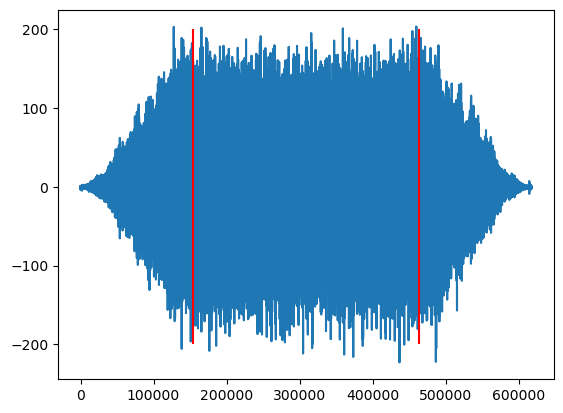

In [31]:
swap = pd.read_csv(os.path.join(raw_data_folder, "ARotor_replication", "1000rpm_CT_baseline_11%_GP8_0.csv"))
plt.plot(swap["acc1"])
plt.vlines([len(swap) * 0.25, len(swap) * 0.75], -200, 200, color="r")
swap.to_feather(os.path.join(raw_data_folder, "ARotor_replication", "1000rpm_CT_baseline_11%_GP8_0.feather"))


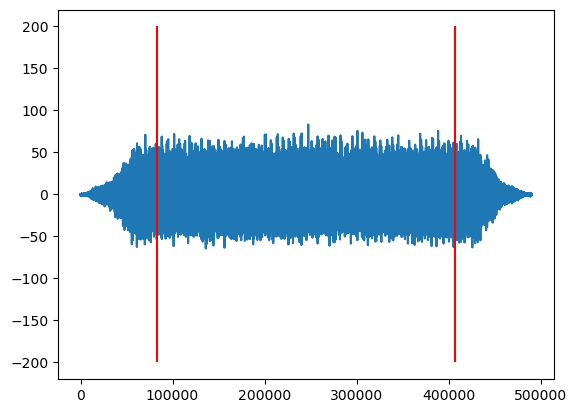

In [41]:
swap = pd.read_csv(os.path.join(raw_data_folder, "ARotor_replication", "500rpm_CT_baseline_6%_GP6_0.csv"))
plt.plot(swap["acc1"])
plt.vlines([len(swap) * 0.17, len(swap) * 0.83], -200, 200, color="r")
swap.to_feather(os.path.join(raw_data_folder, "ARotor_replication", "500rpm_CT_baseline_6%_GP6_0.feather"))


## Recording window fixes


True     794309
False    305591
Name: enc3_ang, dtype: int64


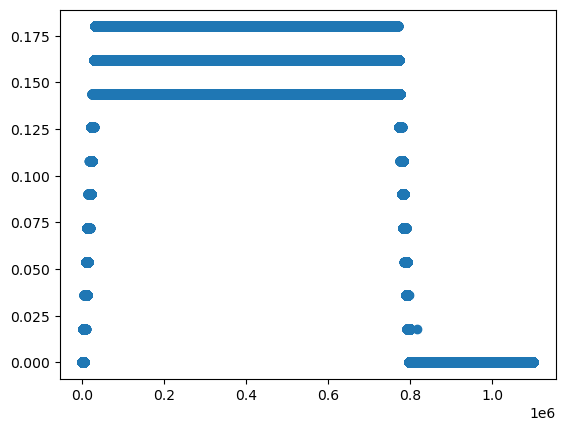

In [64]:
df = pd.read_feather(
    os.path.join(
        raw_data_folder,
        "ARotor_replication",
        "Faults",
        "GP9_mild_tff",
        "data_set_2",
        "3012Hz",
        "sensor",
        "250rpm_CT_failure_11%_GP9_0.feather",
    )
)

y = df["enc3_ang"].diff()

print((y > 0).value_counts())
plt.scatter(range(len(y)), y)


True     856655
False      8445
Name: enc3_ang, dtype: int64


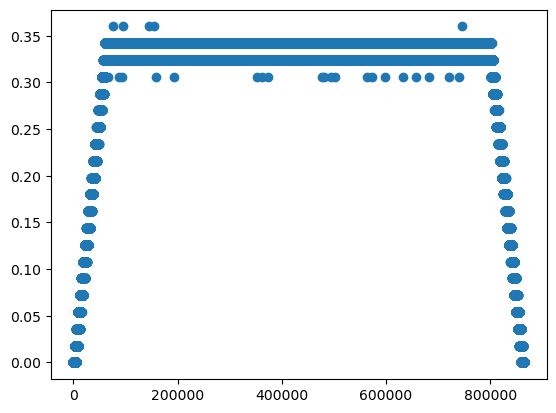

In [65]:
df = pd.read_feather(
    os.path.join(
        raw_data_folder,
        "ARotor_replication",
        "Faults",
        "GP1_mild_pitting",
        "data_set_2",
        "3012Hz",
        "sensor",
        "500rpm_CT_failure_11%_GP1_0.feather",
    )
)

y = df["enc3_ang"].diff()
print((y > 0).value_counts())
plt.scatter(range(len(y)), y)


### Problem cases


True     795903
False     61597
Name: enc3_ang, dtype: int64


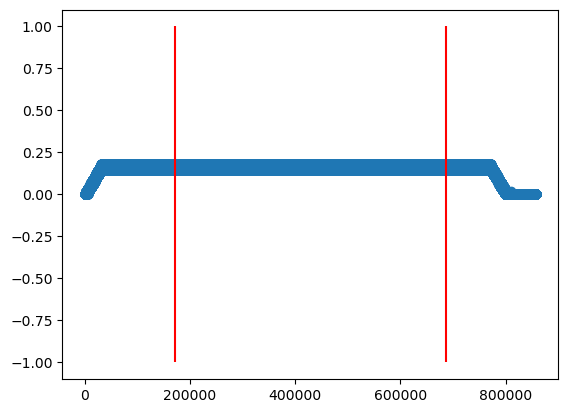

In [78]:
# NOT A PROBLEM

df = pd.read_feather(
    os.path.join(
        raw_data_folder,
        "ARotor_replication",
        "Faults",
        "GP6_severe_pitting",
        "data_set_2",
        "3012Hz",
        "sensor",
        "250rpm_CT_failure_11%_GP6_0.feather",
    )
)

y = df["enc3_ang"].diff()
print((y > 0).value_counts())
plt.scatter(range(len(y)), y)
plt.vlines([len(y) * 0.2, len(y) * 0.8], -1, 1, color="r")


True     1063677
False      45823
Name: enc3_ang, dtype: int64


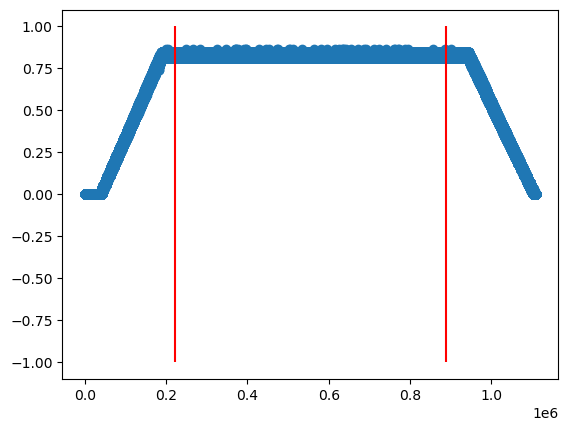

In [109]:
# SMALL PROBLEM (MAYBE USE 0.25 AS LOW?)

df = pd.read_feather(
    os.path.join(
        raw_data_folder,
        "ARotor_replication",
        "Faults",
        "GP7_mild_wear",
        "data_set_2",
        "3012Hz",
        "sensor",
        "1250rpm_CT_failure_11%_GP7_0.feather",
    )
)

y = df["enc3_ang"][15000:].diff()
print((y > 0).value_counts())
plt.scatter(range(len(y)), y)
plt.vlines([len(y) * 0.2, len(y) * 0.8], -1, 1, color="r")


True     919925
False     93875
Name: enc3_ang, dtype: int64


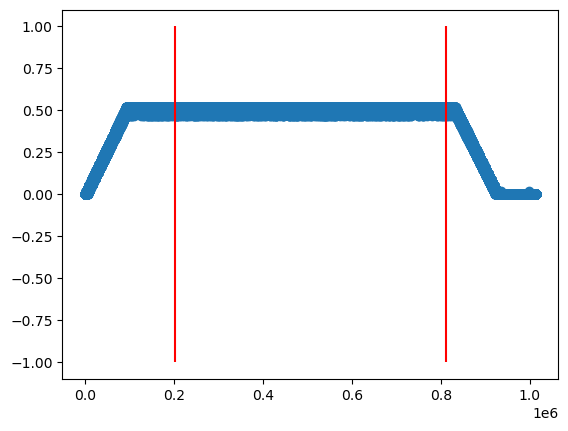

In [105]:
# NOT A PROBLEM

df = pd.read_feather(
    os.path.join(
        raw_data_folder,
        "ARotor_replication",
        "Faults",
        "GP2_severe_wear",
        "data_set_2",
        "3012Hz",
        "sensor",
        "750rpm_CT_failure_6%_GP2_0.feather",
    )
)

y = df["enc3_ang"].diff()
print((y > 0).value_counts())
plt.scatter(range(len(y)), y)
plt.vlines([len(y) * 0.2, len(y) * 0.8], -1, 1, color="r")


True     987108
False     52192
Name: enc3_ang, dtype: int64


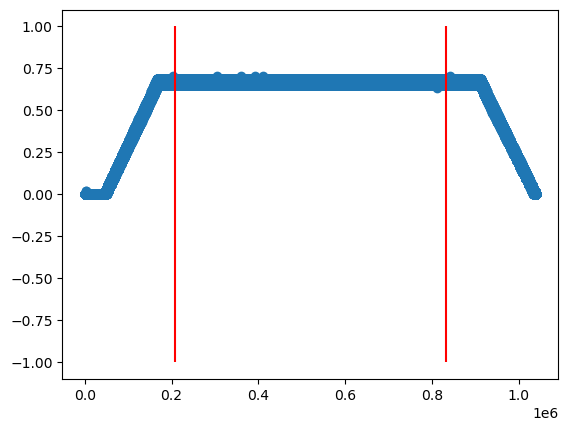

In [106]:
# NOT A PROBLEM

df = pd.read_feather(
    os.path.join(
        raw_data_folder,
        "ARotor_replication",
        "Faults",
        "GP2_severe_wear",
        "data_set_2",
        "3012Hz",
        "sensor",
        "1000rpm_CT_failure_1%_GP2_0.feather",
    )
)

y = df["enc3_ang"].diff()
print((y > 0).value_counts())
plt.scatter(range(len(y)), y)
plt.vlines([len(y) * 0.2, len(y) * 0.8], -1, 1, color="r")


True     794309
False    125591
Name: enc3_ang, dtype: int64


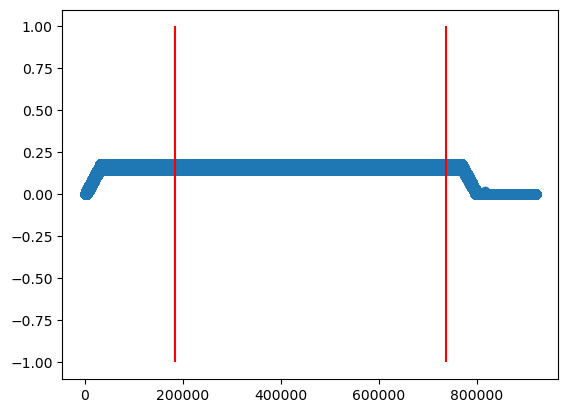

In [104]:
# PROBLEM!!!

df = pd.read_feather(
    os.path.join(
        raw_data_folder,
        "ARotor_replication",
        "Faults",
        "GP9_mild_tff",
        "data_set_2",
        "3012Hz",
        "sensor",
        "250rpm_CT_failure_11%_GP9_0.feather",
    )
)

# y = df["enc3_ang"].diff()
y = df["enc3_ang"][:-180000].diff()
print((y > 0).value_counts())
plt.scatter(range(len(y)), y)
plt.vlines([len(y) * 0.2, len(y) * 0.8], -1, 1, color="r")


True     919590
False     25410
Name: enc3_ang, dtype: int64


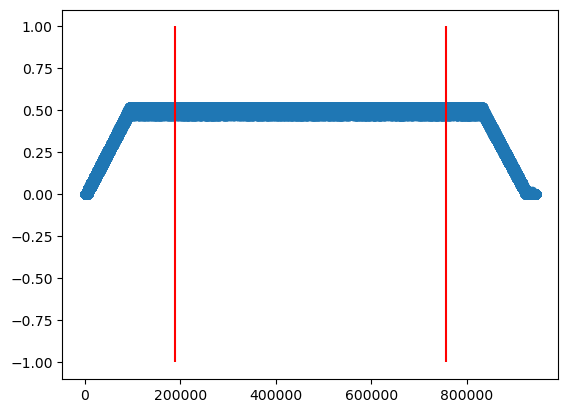

In [83]:
# NOT A PROBLEM

df = pd.read_feather(
    os.path.join(
        raw_data_folder,
        "ARotor_replication",
        "Faults",
        "GP9_mild_tff",
        "data_set_2",
        "3012Hz",
        "sensor",
        "750rpm_CT_failure_11%_GP9_0.feather",
    )
)

y = df["enc3_ang"].diff()
print((y > 0).value_counts())
plt.scatter(range(len(y)), y)
plt.vlines([len(y) * 0.2, len(y) * 0.8], -1, 1, color="r")


## Dataset 2 conversion

csv to feather


In [75]:
dfs = []
# data_folder = os.path.join("data", "RAW", "ARotor_replication", "Faults")
for dirpath, dirnames, filenames in os.walk(os.path.join(raw_data_folder, "ARotor_replication", "Faults")):
    # print(dirnames)
    dirpath_parts = dirpath.split("/")
    for filename in filenames:
        if filename.split(".")[-1] == "csv" and "data_set_2" in dirpath:
            # Load
            pth = os.path.join(dirpath, filename)
            # print(pth)
            df_tmp = pd.read_csv(pth)

            # Check for long zero regions
            if (~(df_tmp["enc1_ang"].diff() > 0)).sum() > 20000:
                # pth = pth.replace(".csv", ".feather").replace("/csv/", "/sensor/")
                # Save
                print(pth)
            # df_tmp.to_feather(pth)


./../../data/RAW/ARotor_replication/Faults/GP6_severe_pitting/data_set_2/3012Hz/csv/250rpm_CT_failure_11%_GP6_0.csv
./../../data/RAW/ARotor_replication/Faults/GP7_mild_wear/data_set_2/3012Hz/csv/1250rpm_CT_failure_11%_GP7_0.csv
./../../data/RAW/ARotor_replication/Faults/GP2_severe_wear/data_set_2/3012Hz/csv/750rpm_CT_failure_6%_GP2_0.csv
./../../data/RAW/ARotor_replication/Faults/GP2_severe_wear/data_set_2/3012Hz/csv/1000rpm_CT_failure_1%_GP2_0.csv
./../../data/RAW/ARotor_replication/Faults/GP9_mild_tff/data_set_2/3012Hz/csv/250rpm_CT_failure_11%_GP9_0.csv
./../../data/RAW/ARotor_replication/Faults/GP9_mild_tff/data_set_2/3012Hz/csv/750rpm_CT_failure_11%_GP9_0.csv


### Manual fixing


In [111]:
pth = os.path.join(
    raw_data_folder,
    "ARotor_replication",
    "Faults",
    "GP9_mild_tff",
    "data_set_2",
    "3012Hz",
    "sensor",
    "250rpm_CT_failure_11%_GP9_0.feather",
)
df = pd.read_feather(pth)
df = df[:-180000]  # Cut from end
df.to_feather(pth)


In [113]:
pth = os.path.join(
    raw_data_folder,
    "ARotor_replication",
    "Faults",
    "GP7_mild_wear",
    "data_set_2",
    "3012Hz",
    "sensor",
    "1250rpm_CT_failure_11%_GP7_0.feather",
)

df = pd.read_feather(pth)
df = df[15000:].reset_index(drop=True)  # Cut from end
df.to_feather(pth)
